In [1]:
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
import numpy as np

In [5]:
import scipy.stats as stats

In [6]:
muap_df = pd.read_csv("../../data/muap.csv")

In [7]:
muap_df["Cls"] = muap_df["Cls"].apply(lambda x: {
    1: "Normal",
    2: "MND",
    3: "Myopathy"
}[x])

In [8]:
muap_df.drop(columns=["Pat.No."], inplace=True)

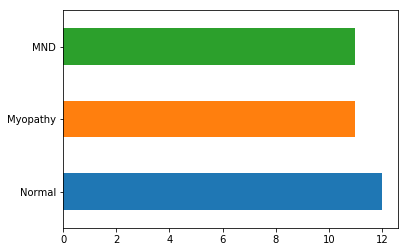

In [9]:
muap_df["Cls"].value_counts().plot(kind="barh")

# Pearson correlations
The simple first step. What features seems to be interconnected with the presence of the disease?

In [10]:
class_df = muap_df["Cls"]
muap_df = pd.get_dummies(muap_df)
muap_df["Cls"] = class_df

In [11]:
muap_df.corr().loc[
    [c for c in muap_df.columns if "Cls" not in c], 
    [c for c in muap_df.columns if "Cls_" in c]
]

,Cls_MND,Cls_Myopathy,Cls_Normal
DurMn,0.818070,-0.699702,-0.115876
DurSD,0.671828,-0.606609,-0.063846
AmpMn,0.847803,-0.566037,-0.275833
AmpSD,0.666969,-0.379789,-0.281133
SpDMn,0.532937,-0.500261,-0.031988
SpDSD,0.578367,-0.546925,-0.030780
SpAMn,0.810965,-0.527092,-0.277896
SpASD,0.761341,-0.379311,-0.373987
PhMn,0.760677,-0.302776,-0.448260
PhSD,0.607260,-0.141027,-0.456417


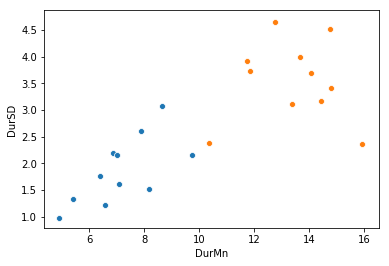

In [13]:
sns.scatterplot(data=muap_df[muap_df["Cls_Myopathy"] == 1], x="DurMn", y="DurSD")
sns.scatterplot(data=muap_df[muap_df["Cls_MND"] == 1], x="DurMn", y="DurSD")

# Explanation
Duration features (DurMn, DurSD) seems to be correlated with MND presence and with Myopathy absense. Is there a reason for such correlation?

For this step, we should look into the article. It says that:

- For MND: "Motor unit potentials with duration values that are longer than normal ... are typical findings in MND. ... The latter effect is the result of slowed conduction along the terminal branches of individual nerve fibers"

- For Myopathy: "MUAP’s with short duration are typical findings in patients suffering from myopathy. These findings are attributed to fiber loss within the motor unit"

So, the difference in DurMn feature can be explained with the difference of biological processes in the tissues of MND (nerve conduction impairment) and Myopathy (motor fiber loss) patients.

# Statistical test

Our dataset is very small, it contains only 34 records - that is a common situation for medical data. So we cannot be sure if the DurMn feature can really be significant for class separation, or this difference appeared by chance. We should show the statistical significance of the difference in DurMn values between classes.

### What is statistical significance?

Let's look at the following example situation. We've selected some points with `np.random.randn` from the same distribution $N(0, 1)$. But it appears to be that the values in the first half of the generated sample is smaller than in the rest.

In [14]:
sample = [0.18087853, 0.11171142, 0.09779717, 0.55061778, 0.12703509, 0.88666074, 0.87662885, 0.58955246, 0.74943889, 0.91228432]
sample

[0.18087853,
 0.11171142,
 0.09779717,
 0.55061778,
 0.12703509,
 0.88666074,
 0.87662885,
 0.58955246,
 0.74943889,
 0.91228432]

In [15]:
classes = [0] * 5 + [1] * 5
classes

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [16]:
sample_df = pd.DataFrame(np.array([sample, classes]).T, columns=["value", "class"])

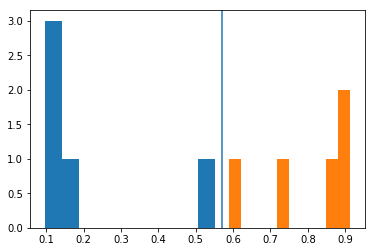

In [17]:
plt.hist(sample_df[sample_df["class"] == 0]["value"])
plt.hist(sample_df[sample_df["class"] == 1]["value"])
plt.axvline(0.57)
plt.show()

The groups can obviously be separated by the given threshold. But, as was mentioned above, both halves were taken from the same distribution. Is it a way to avoid the judgment about the groups difference in such situation? 

In such cases, the final conclusion can be made using a statistical test. Let's consider each step of this process with one-sample parametric Z-test as an example. 

**Null and alternative hypothesis**

First of all, we need to put hypotheses. They are the statements which possibility will be compared against each other to find the most plausible one. For the described case, we can compare the center of each group with standard normal distribution mean with known variation (because for now this parameter is out of interest). 
$$ H_0: \mu = 0 $$
$$ H_1: \mu = \mu_1, \mu_1 \neq 0 $$

In such case, $H_0$ is called null hypothesis, and $H_1$ is called an alternative. If null hypothesis is the most probable for both groups, then the difference between their centers can be considered as non-significant.

**Test statistics**

How to find the most probable hypothesis? It can be done by the actual calculation of its probability on the given data, i.e.
$$ L(X|\theta) = \prod_i p(x_i|\theta)$$

Where $X$ is the given sample, $x_i$ is the point $i$, $\theta$ is the parameter of the distribution suggested in hypothesis. $L$ function, called likelihood, is used to build an optimal test by the Neumann-Pearson lemma. 

We can use the following fraction to compare likelihoods for null and alternative hypotheses:

$$ \phi = \frac{L(X|\theta_1)}{L(X|\theta_0)} \geq C $$

If the inequality is correct for given $X$, then the alternative hypothesis is more plausible to match the given data. 

For Z-test, where $p(x_i|\mu)$ in $L$ equation can be represented with normal distribution formula with known standard deviation $\sigma$, it is possible to simplify $\phi$ fraction as:

$$ \sum_i x_i \leq C'_1 $$
$$ \sum_i x_i \geq C'_2 $$

In both cases, the values for $C$ and $C'_1, C'_2$ are selected based on the significance level

** Significance level **

There are two types of statistical conclusion errors possible. 
- Type I error - occurs when you incorrectly reject a true null hypothesis
- Type II error - occurs when you failed to reject a false null hypothesis

The probability of Type I error for the test $\alpha$ is called significance level. The inverse probability of Type II error $(1 - \beta)$ is called test power.

It is impossible to reduce the probability of both errors to zero in general case, but we can fix the significance level (values of 5% or 1% are used in most cases) and then increase test power as much as possible. According to Neumann-Pearson lemma, such optimum can be achieved if null hypothesis will be rejected for $\alpha$% of all possible datasets $X$. 

For Z-test, the search of $C'_1, C'_2$ values can be simplified to the following equation:
$$ C'_1 = n\mu_0 + u_{\alpha / 2}\sigma\sqrt n $$
$$ C'_2 = n\mu_0 + u_{1 - \alpha / 2}\sigma\sqrt n $$

Where $u_{x}$ is the x-level quantile of $N(0, 1)$

To avoid the usage of quantiles for Z-test, it is possible to compare the probability of $\phi$ (or Z) value (called p-value) with an actual significance level.
$$ Z = \frac{\sum_i x_i - n\mu}{\sqrt{n}\sigma} $$

I.e. the value of Z should be between $\alpha / 2$ and $1 - \alpha / 2$ to make null hypothesis acceptable.

The process of Z-test usage is shown below

In [18]:
def z_test_p_value(x, mu=0, std=1, threshold=0.05):
    z = (x.mean() - mu) / (std / np.sqrt(x.shape[0]))
    return stats.norm.pdf(z), (stats.norm.pdf(z) > threshold / 2) & (stats.norm.pdf(z) < (1 - threshold) / 2)

In [19]:
z_test_p_value(sample_df[sample_df["class"] == 0]["value"])

(0.3559341720398134, True)

In [20]:
z_test_p_value(sample_df[sample_df["class"] == 1]["value"])

(0.07961028739238718, True)

So, if the significant level is 5%, then in both cases there is a significant probability that the sample was taken from standard normal distribution. I.e. the presented difference between samples is statistically insignificant.

### Statistical significance of DurMn 

Z-test is an example of one-sample parametric test. In most cases, it is barely possible to say that the feature can be represented by the certain distribution. As an example of non-parametric two-sample test, the authors of the paper used Mann-Whitney U to check is the difference statistically significant.  

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


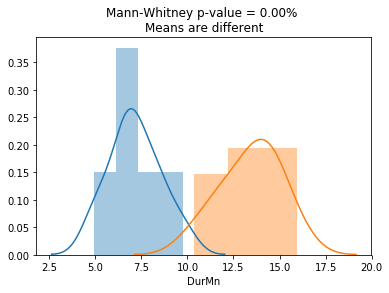

In [21]:
sns.distplot(muap_df[muap_df["Cls_Myopathy"] == 1]["DurMn"])
sns.distplot(muap_df[muap_df["Cls_MND"] == 1]["DurMn"])
p_value = stats.mannwhitneyu(muap_df[muap_df["Cls_Myopathy"] == 1]["DurMn"], muap_df[muap_df["Cls_MND"] == 1]["DurMn"]).pvalue
plt.title("Mann-Whitney p-value = {0:.2f}% \nMeans are different".format(p_value * 100))

So, the difference in DurMn for MND and Myopathy patients can be explained biologically, and the dataset is representative enough to show it.